In [5]:
import lightgbm
import numpy as np
import pandas as pd

## Generate Predictions Func

In [6]:
def generate_predictions(df_kpi, date_uploaded, model_object, backtesting_limit=360):
    df_kpi = df_kpi[df_kpi['backtesting_limit'] == backtesting_limit].reset_index().drop(columns = 'index')
    col_720 = [col for col in df_kpi.columns if '_720' in col]
    col_630 = [col for col in df_kpi.columns if '_630' in col]
    col_540 = [col for col in df_kpi.columns if '_540' in col]
    col_450 = [col for col in df_kpi.columns if '_450' in col]

    col_450_540_630_720 = col_720+col_630+col_540+col_450
    col_540_630_720 = col_720+col_630+col_540
    col_630_720 = col_720+col_630

    df_kpi.loc[(df_kpi['cohort_age_backtesting']==360),col_450_540_630_720] = np.nan
    df_kpi.loc[(df_kpi['cohort_age_backtesting']==450),col_540_630_720] = np.nan
    df_kpi.loc[(df_kpi['cohort_age_backtesting']==540),col_630_720] = np.nan
    df_kpi.loc[(df_kpi['cohort_age_backtesting']==630),col_720] = np.nan
    
    preds = model_object.predict(df_kpi[model_object.feature_name()])
    df_kpi["predictions"] = preds
    
    for months in [360, 450, 540, 630, 720]:
        frr_col = f"frr_{months}"
        mask = (df_kpi["age_in_months"] == months) & (df_kpi[frr_col] > df_kpi["predictions"])
        df_kpi.loc[mask, "predictions"] = df_kpi[frr_col]

    df_kpi["predictions"] = df_kpi["predictions"].clip(lower=0, upper=1)
    df_kpi["date_uploaded"] = date_uploaded
    df_kpi["date_uploaded"] = pd.to_datetime(df_kpi["date_uploaded"], format="%Y-%m-%d")
    df_kpi["reg_month"] = pd.to_datetime(df_kpi["reg_month"], format="%Y-%m")
    df_kpi["predicted_revenue_3_years_50"] = np.round(df_kpi['predictions']*df_kpi['total_follow_on_revenue_current_usd'],2)
    return df_kpi


## Load Data

In [7]:
# model_1 = lightgbm.Booster(model_file = "quantile_regression_360_0.5_days_2025-09-29.txt")

model_1 = lightgbm.Booster(model_file = "../data/quantile_regression_360_0.5_days_2025-02-23.txt")

In [8]:
kpi_processed_file = '../data/KPIs_data_processed_2025-10-01.csv'
df_kpi = pd.read_csv(kpi_processed_file)
df_preds_sep = generate_predictions(df_kpi=df_kpi, date_uploaded="2025-10-01", model_object=model_1, backtesting_limit=360)

kpi_processed_file = '../data/KPIs_data_processed_2025-09-01.csv'
df_kpi = pd.read_csv(kpi_processed_file)
df_preds_aug = generate_predictions(df_kpi=df_kpi, date_uploaded="2025-09-01", model_object=model_1, backtesting_limit=360)

df2 = pd.concat([df_preds_sep, df_preds_aug])
print(df2.shape)
df2_copy = df2.copy()

(341829, 92)


## Example Data Point

In [9]:
df2_copy[df2_copy.accounts_group=='2024-05_Kenya_Lanterns_Kakamega_Sun King Boom EasyBuy'][["accounts_group", "frr_360", "frr_450", "frr_540", "cohort_age_backtesting", "date_uploaded", "predictions"]]

,accounts_group,frr_360,frr_450,frr_540,cohort_age_backtesting,date_uploaded,predictions
153195,2024-05_Kenya_Lanterns_Kakamega_Sun King Boom ...,0.564007,0.672026,NaN,450,2025-10-01,0.883211
153074,2024-05_Kenya_Lanterns_Kakamega_Sun King Boom ...,0.564007,0.672026,NaN,450,2025-09-01,0.883211


In [10]:
df2= df2.drop(["current_horizon", "predicted_revenue_3_years_50"], axis=1, errors="ignore")
df2

,accounts_group,reg_month,country,product_group,area,primary_product,count_units,avg_planned_repayment_days,total_follow_on_revenue_current_usd,total_follow_on_revenue,...,age_in_months,exchange,total_follow_on_revenue_usd_cal,total_follow_on_revenue_usd_final,avg_upfront_price_usd,avg_unlock_price_usd,backtesting_limit,cohort_age_backtesting,predictions,date_uploaded
0,2016-01_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-01-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,57,77,1542.804066,199500.0,...,116,152.85,1305.2012,1305.201200,7.0,30.0,360,720,0.977491,2025-10-01
1,2016-02_Kenya_Lanterns_Bungoma_Sun King Pro Ea...,2016-02-01,Kenya,Lanterns,Bungoma,Sun King Pro EasyBuy,18,77,487.201284,63000.0,...,115,152.85,412.1688,412.168800,7.0,30.0,360,720,0.912855,2025-10-01
2,2016-02_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-02-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,287,77,7768.153806,1004500.0,...,115,152.85,6571.8024,6571.802400,7.0,30.0,360,720,0.958276,2025-10-01
3,2016-03_Kenya_Lanterns_Bungoma_Sun King Pro Ea...,2016-03-01,Kenya,Lanterns,Bungoma,Sun King Pro EasyBuy,114,77,3085.608132,399000.0,...,114,152.85,2610.4024,2610.402400,7.0,30.0,360,720,0.928347,2025-10-01
4,2016-03_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-03-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,142,77,3843.476796,497000.0,...,114,152.85,3251.5538,3251.553800,7.0,30.0,360,720,0.945235,2025-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168589,2024-08_Zambia_SHS without TV_Mumbwa_Sun King ...,2024-08-01,Zambia,SHS without TV,Mumbwa,Sun King Home 500x EasyBuy,16,369,3264.341409,75341.0,...,12,25.30,2977.9051,2889.424781,19.0,200.0,360,360,0.977017,2025-09-01
168590,2024-08_Zambia_SHS without TV_Ndola_Sun King H...,2024-08-01,Zambia,SHS without TV,Ndola,Sun King Home 500x EasyBuy,97,357,19643.890743,453381.0,...,12,25.30,17920.1976,17387.747660,20.0,200.0,360,360,0.992895,2025-09-01
168591,2024-08_Zambia_SHS without TV_Serenje_Sun King...,2024-08-01,Zambia,SHS without TV,Serenje,Sun King Home 500x EasyBuy,7,353,1365.251295,31510.0,...,12,25.30,1245.4545,1208.449249,19.0,192.0,360,360,0.795873,2025-09-01
168592,2024-08_Zambia_SHS without TV_Situmbeko_Sun Ki...,2024-08-01,Zambia,SHS without TV,Situmbeko,Sun King Home 500x EasyBuy,19,350,3767.331009,86950.0,...,12,25.30,3436.7589,3334.644943,20.0,196.0,360,360,0.990850,2025-09-01


In [11]:
# df = df2.groupby(["accounts_group", "reg_month", "country", "product_group", "area", "primary_product", "count_units", "total_follow_on_revenue_current_usd", "date_uploaded"]).agg(
#     predicted_frr_agg= ("predictions", "mean")
# ).reset_index()

df = df2

In [12]:
df[df.accounts_group=='2024-05_Kenya_Lanterns_Kakamega_Sun King Boom EasyBuy']

,accounts_group,reg_month,country,product_group,area,primary_product,count_units,avg_planned_repayment_days,total_follow_on_revenue_current_usd,total_follow_on_revenue,...,age_in_months,exchange,total_follow_on_revenue_usd_cal,total_follow_on_revenue_usd_final,avg_upfront_price_usd,avg_unlock_price_usd,backtesting_limit,cohort_age_backtesting,predictions,date_uploaded
153195,2024-05_Kenya_Lanterns_Kakamega_Sun King Boom ...,2024-05-01,Kenya,Lanterns,Kakamega,Sun King Boom EasyBuy,1360,408,85365.246144,11038580.0,...,16,152.85,72218.384,83588.098658,3.0,65.0,360,450,0.883211,2025-10-01
153074,2024-05_Kenya_Lanterns_Kakamega_Sun King Boom ...,2024-05-01,Kenya,Lanterns,Kakamega,Sun King Boom EasyBuy,1360,408,85398.266724,11038580.0,...,15,152.85,72218.384,83588.098658,3.0,65.0,360,450,0.883211,2025-09-01


In [13]:
df["predicted_revenue_3_years"] = np.round(df['predictions']*df['total_follow_on_revenue_current_usd'],2)

## Visuals by Country

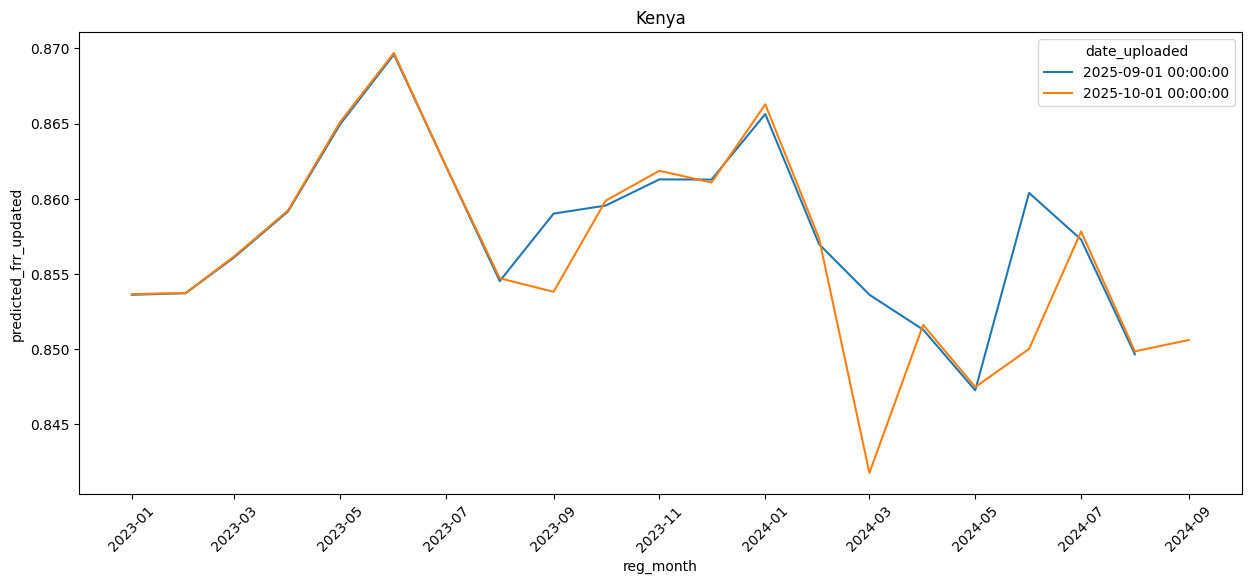

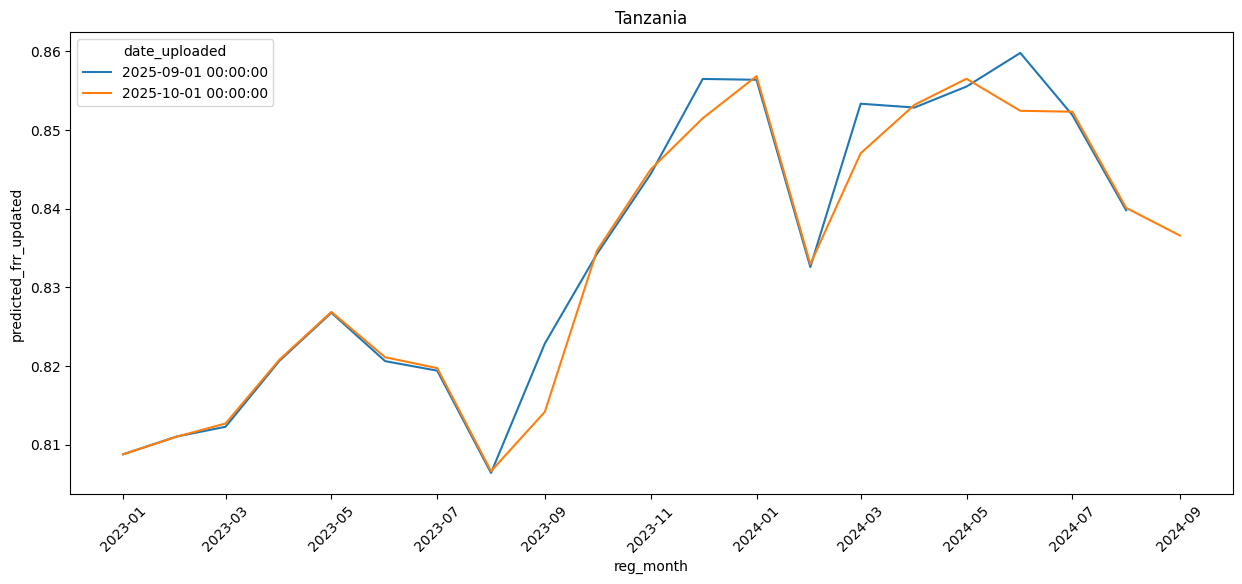

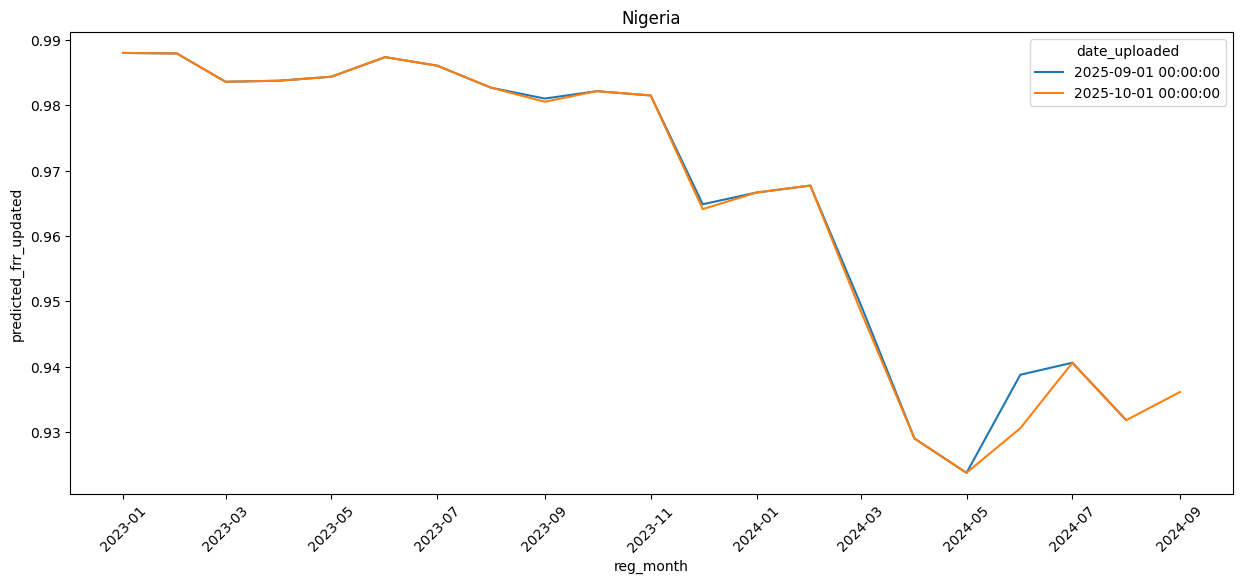

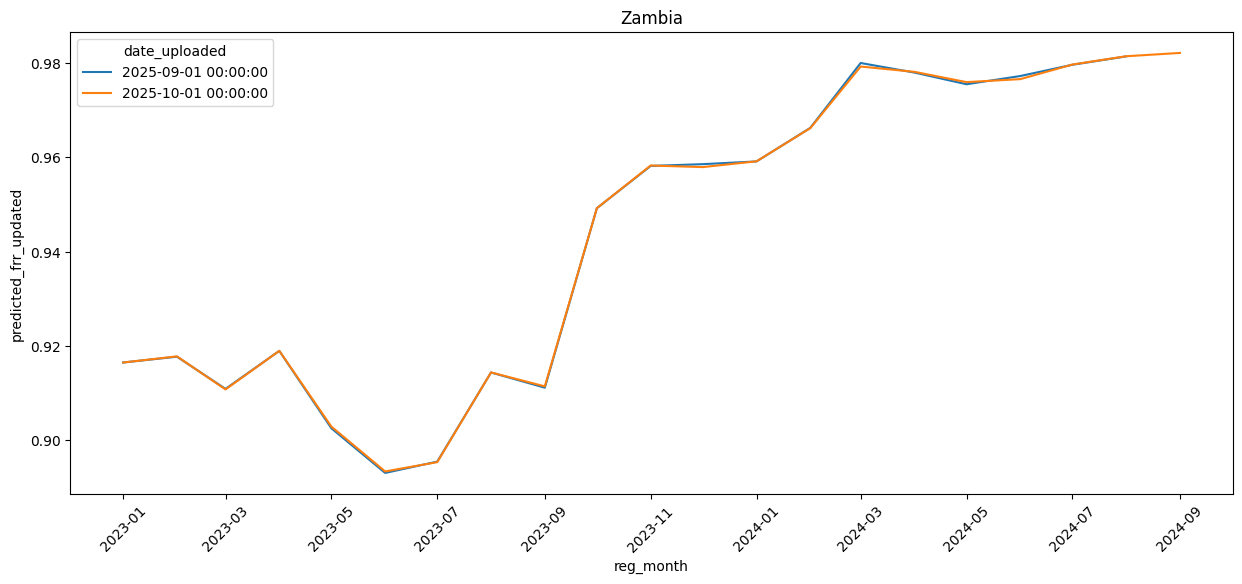

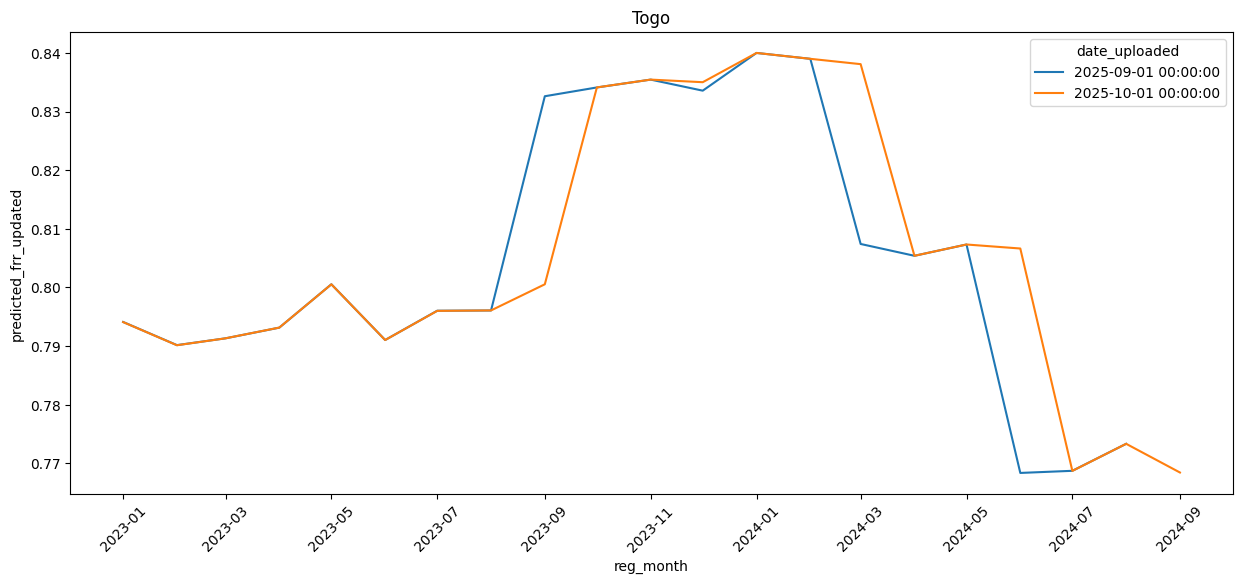

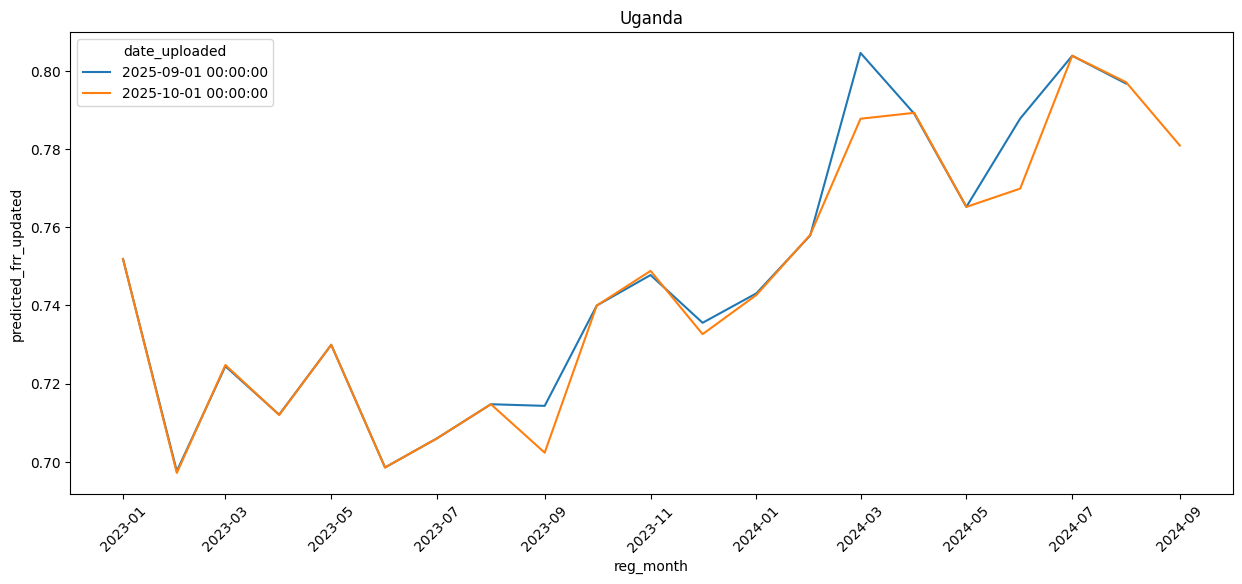

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns

df_country = df.groupby(["country", "reg_month", "date_uploaded"]).agg(
    count_average=("count_units", lambda x: int(x.mean())),
    predicted_fr = ("predicted_revenue_3_years", "sum"),
    total_fr = ("total_follow_on_revenue_current_usd", "sum")
).reset_index()
df_country["predicted_frr_updated"] = df_country.predicted_fr/df_country.total_fr
df_country = df_country.drop(['total_fr', 'predicted_fr'], axis=1)
# products = ["Lanterns", "Phones", "SHS Entry-Level", "SHS with TV", "SHS without TV", "SHS Entry-Level Upgrade", "SHS with TV Upgrade"]
# df_country = df_country[df_country.product_group.isin(products)]
df_country

for country in ["Kenya", "Tanzania", "Nigeria", "Zambia", "Togo", "Uganda"]:
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_country[(df_country.country==country) & (df_country.reg_month>="2023-01-01")], x="reg_month", y="predicted_frr_updated",\
                  hue="date_uploaded")
    # sns.lineplot(data=df_country, x="reg_month", y="frr_prediction_50")
    plt.xticks(rotation=45)
    plt.title(country)
    plt.show()

In [15]:
df_country[df_country["country"]=="Kenya"].tail(10)

,country,reg_month,date_uploaded,count_average,predicted_frr_updated
404,Kenya,2024-04-01,2025-10-01,70,0.851613
405,Kenya,2024-05-01,2025-09-01,73,0.847263
406,Kenya,2024-05-01,2025-10-01,73,0.847480
407,Kenya,2024-06-01,2025-09-01,61,0.860386
408,Kenya,2024-06-01,2025-10-01,61,0.850008
409,Kenya,2024-07-01,2025-09-01,58,0.857287
410,Kenya,2024-07-01,2025-10-01,58,0.857820
411,Kenya,2024-08-01,2025-09-01,52,0.849652
412,Kenya,2024-08-01,2025-10-01,52,0.849852
413,Kenya,2024-09-01,2025-10-01,46,0.850606


In [16]:
0.851948 - 0.859237

-0.00728899999999999

## Visuals by Country and Product

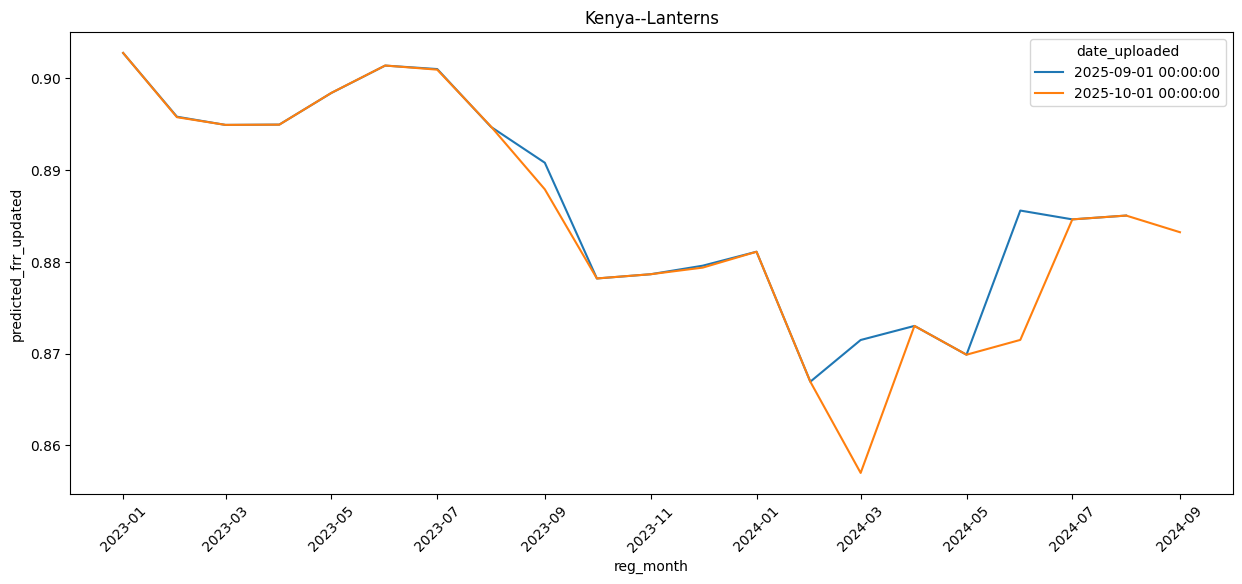

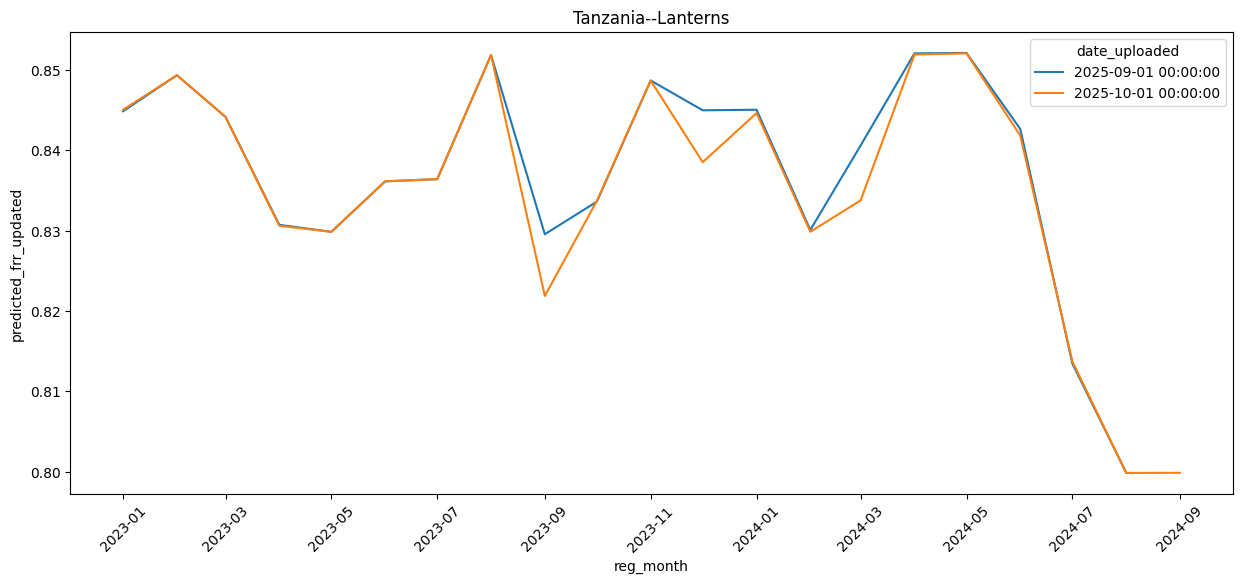

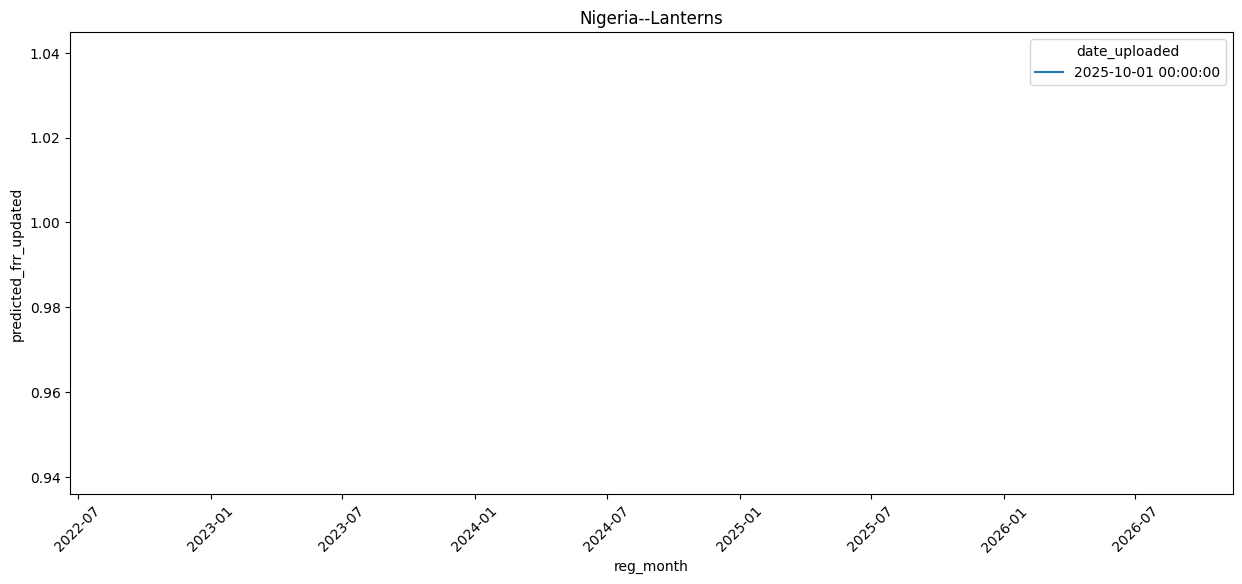

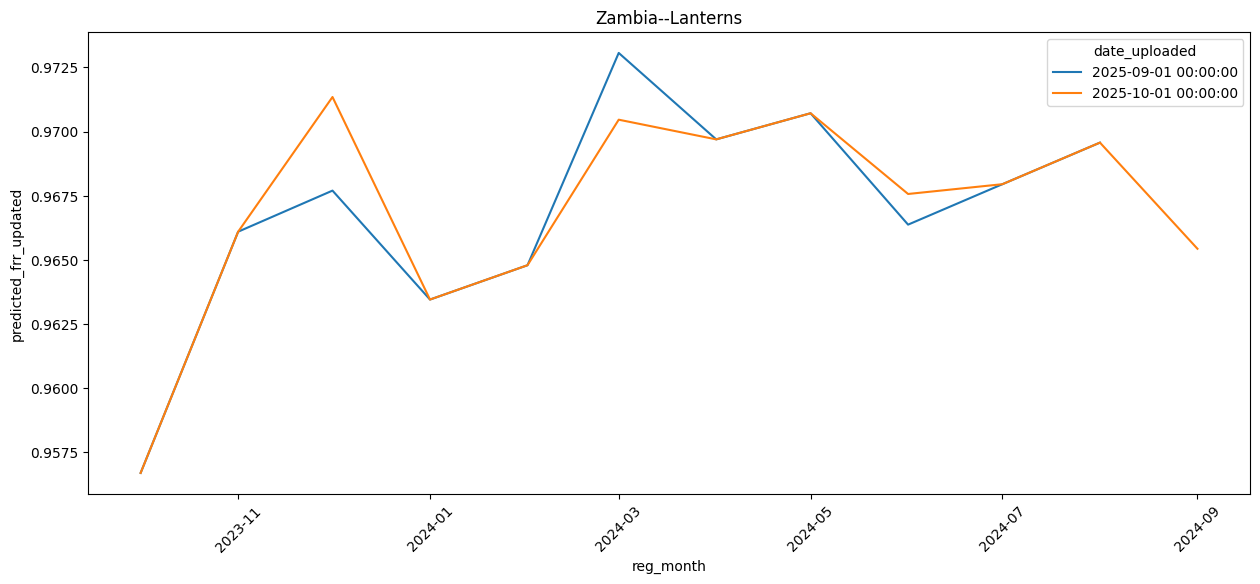

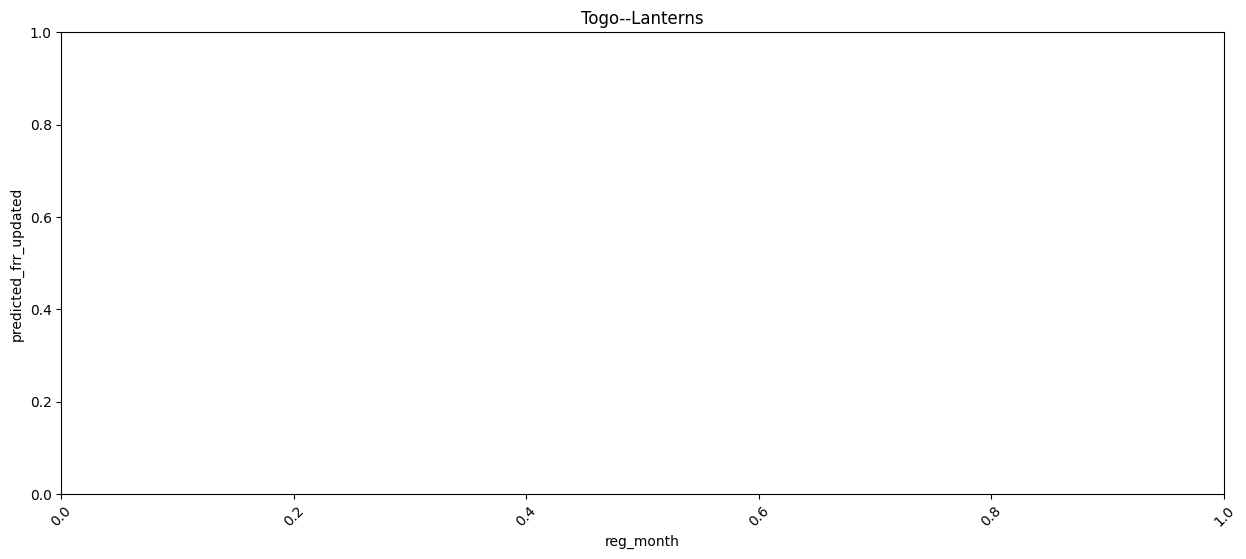

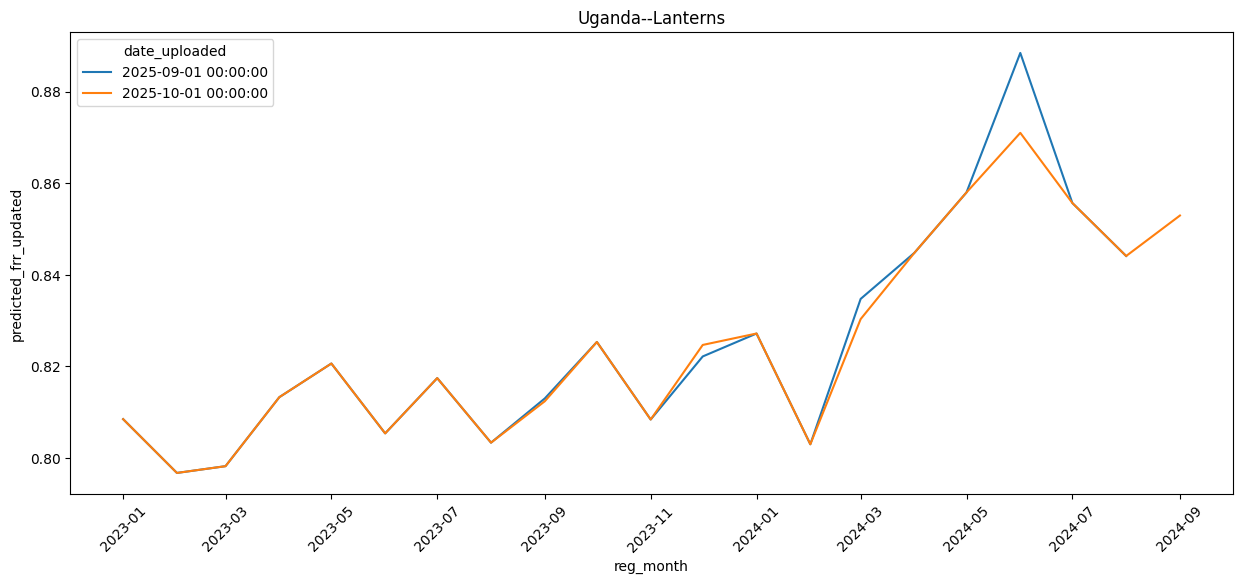

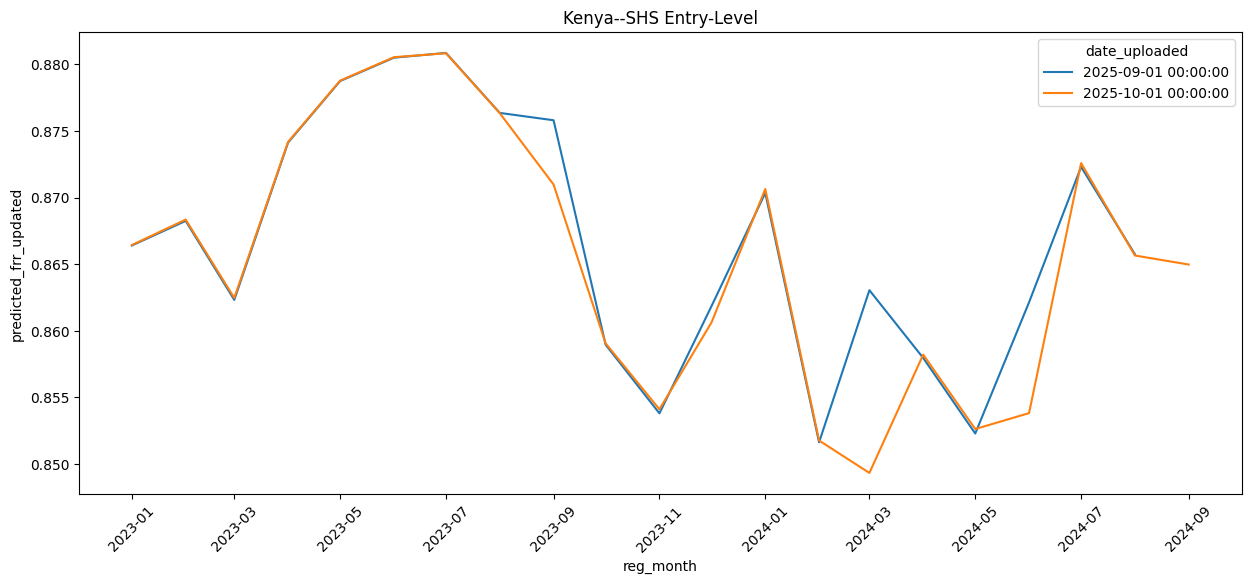

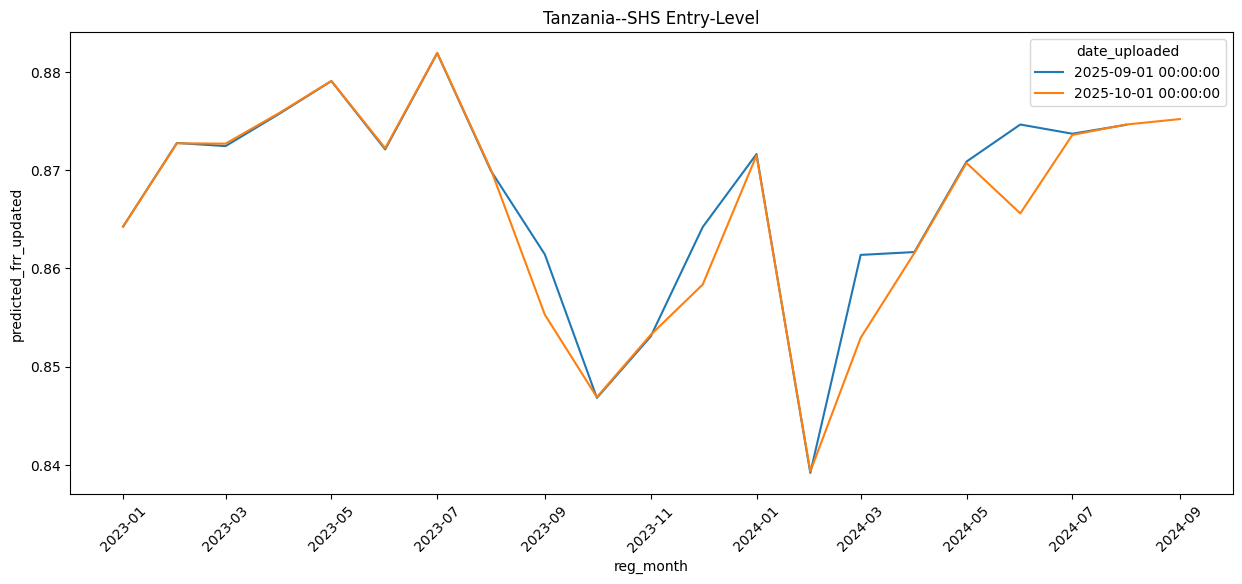

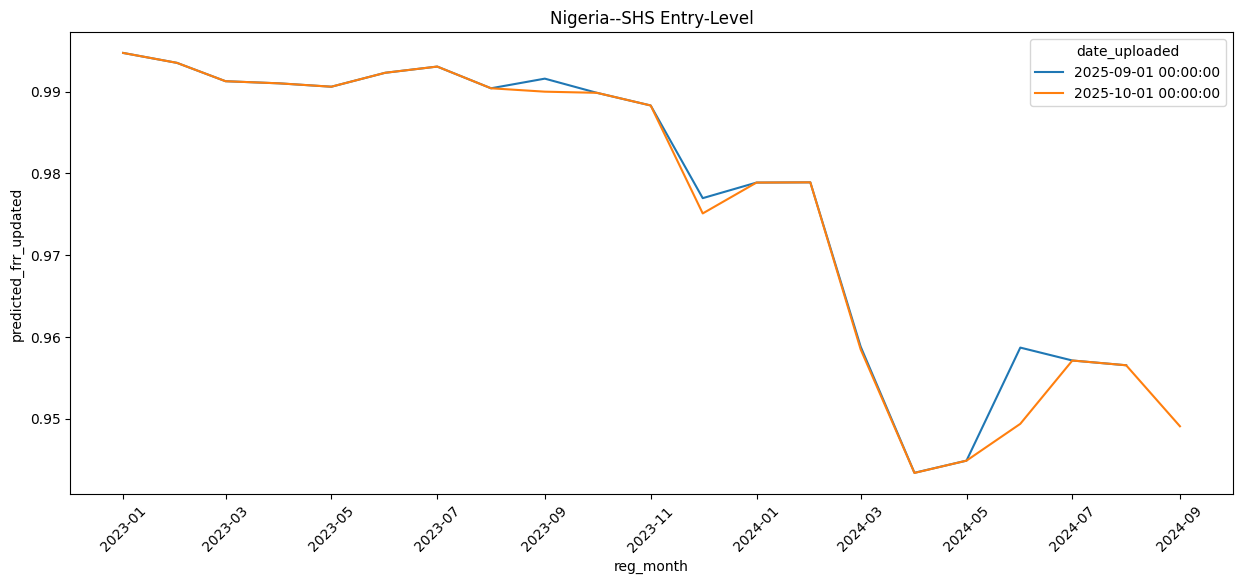

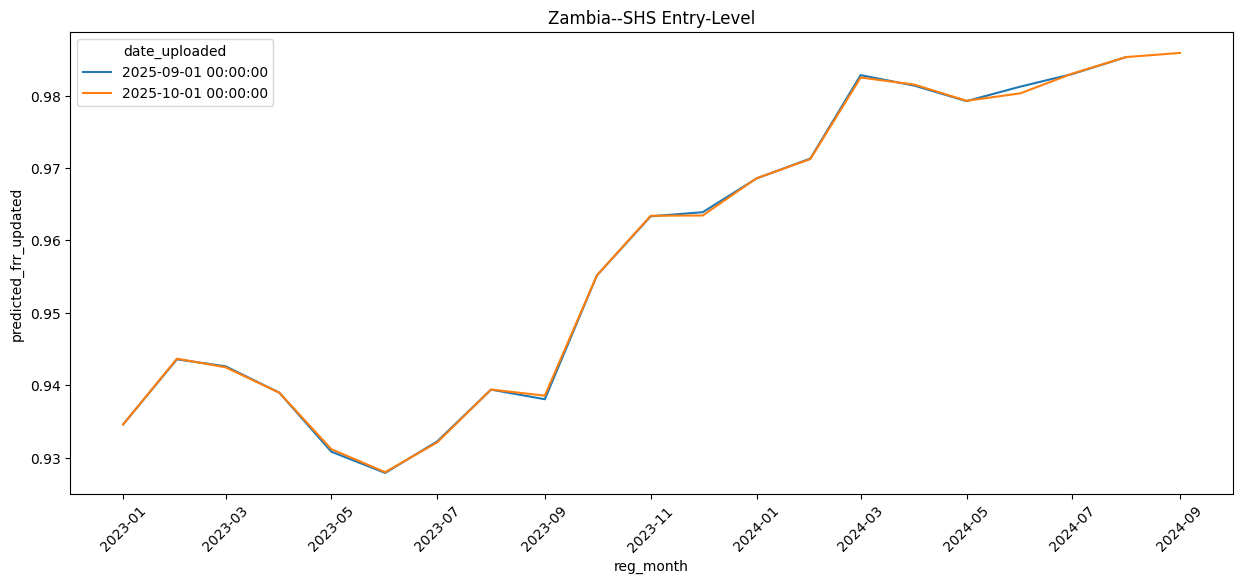

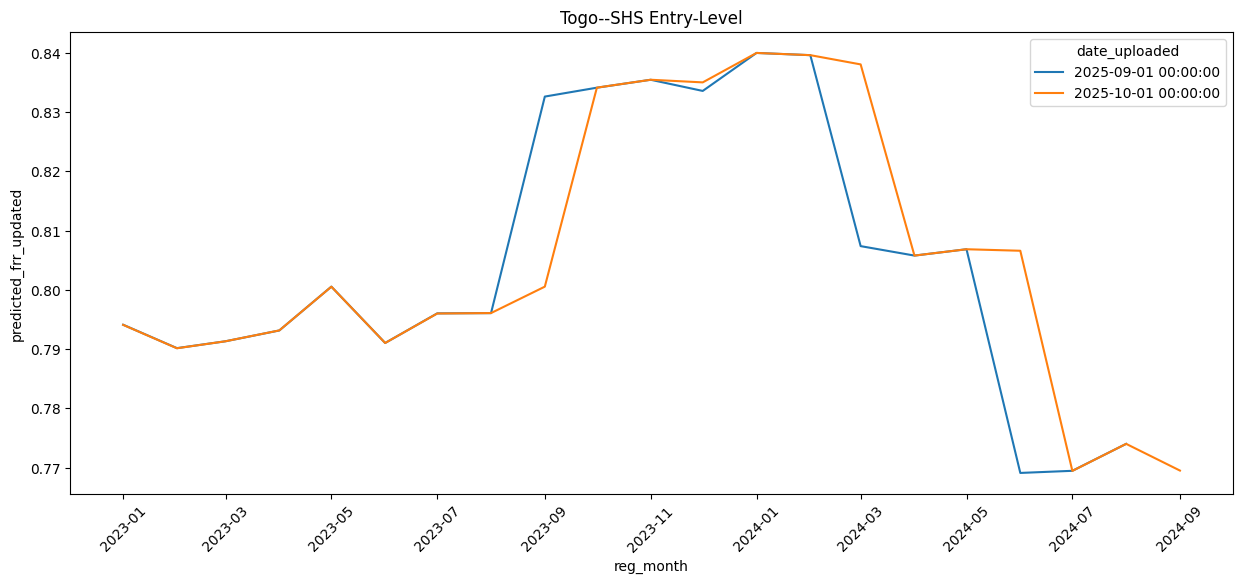

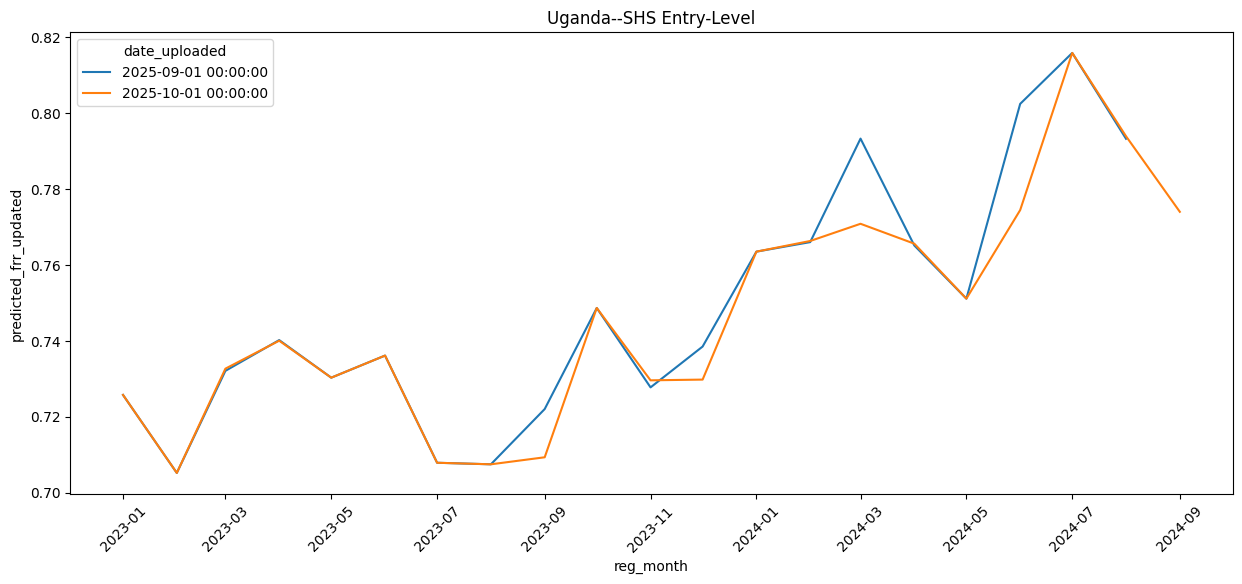

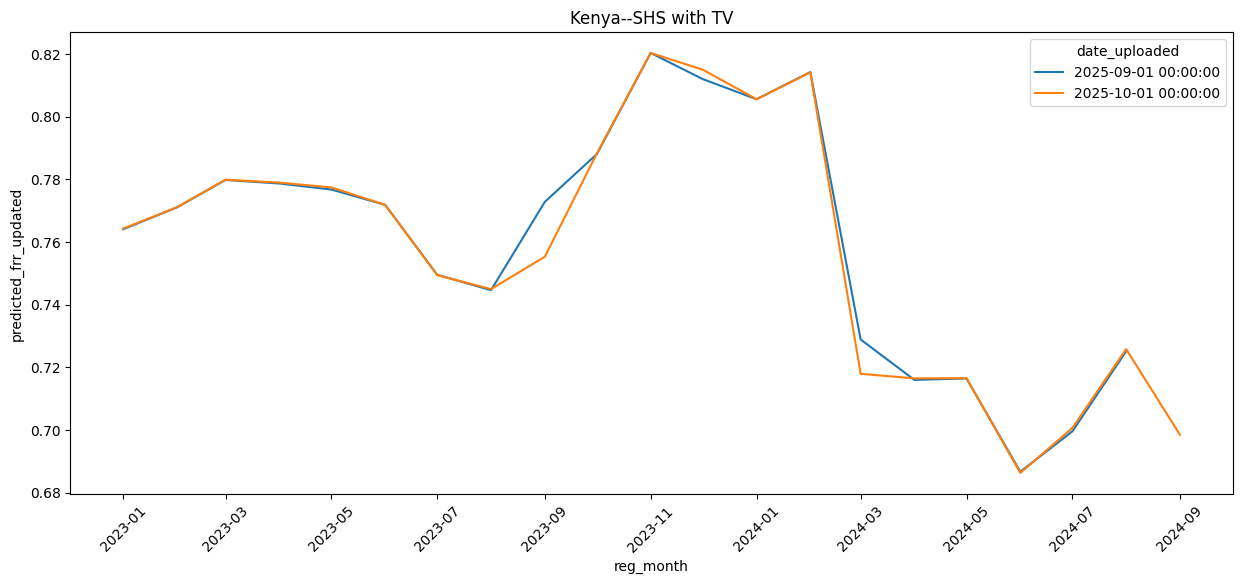

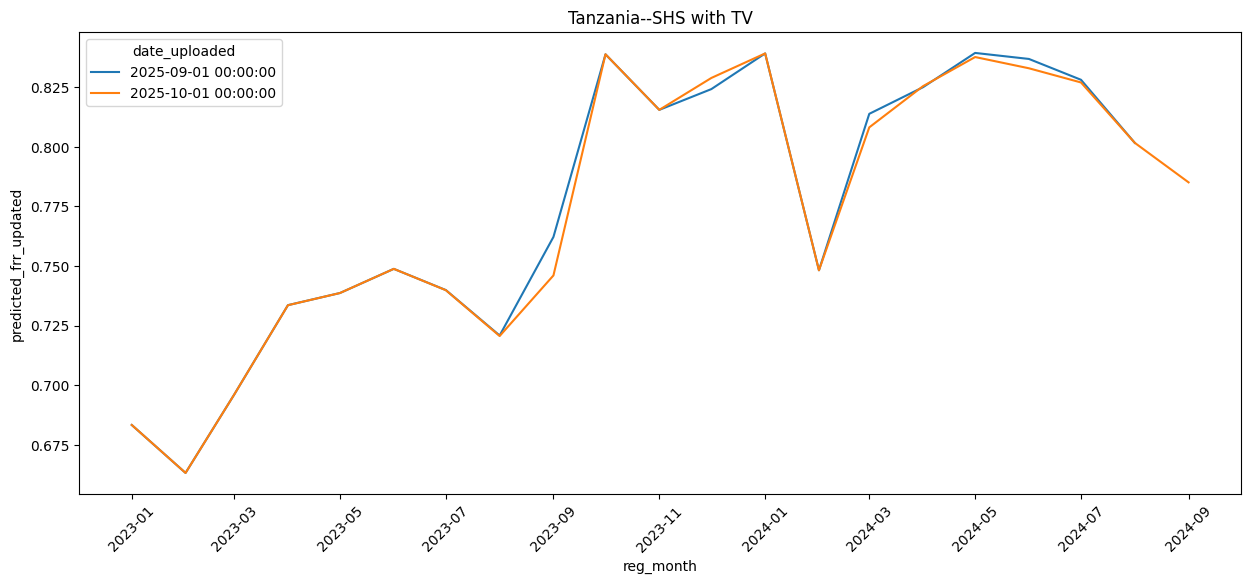

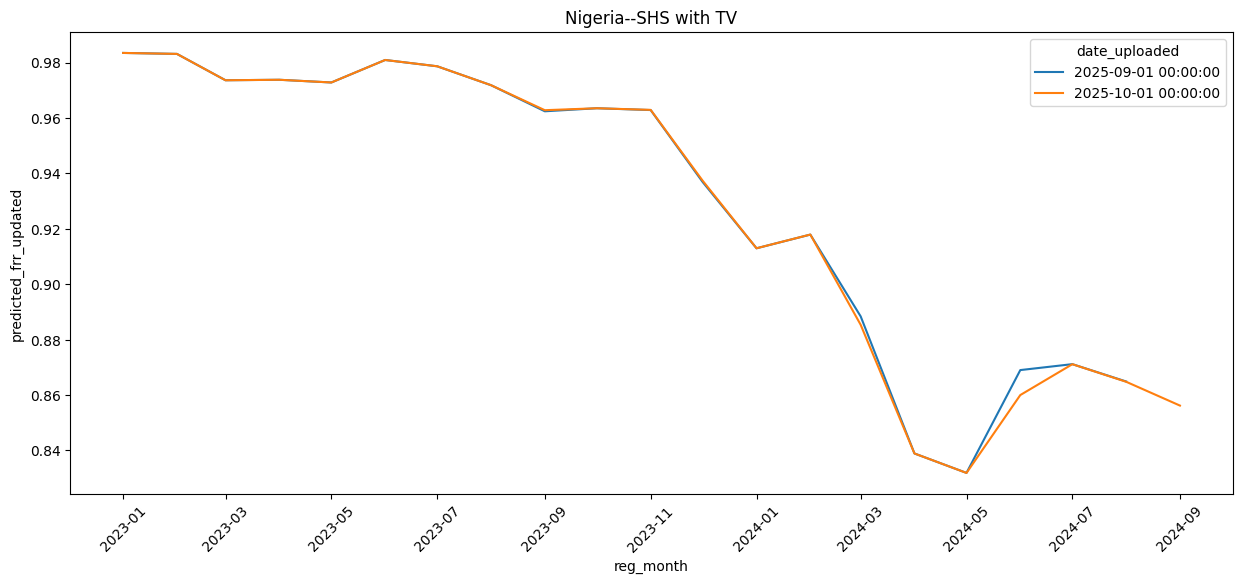

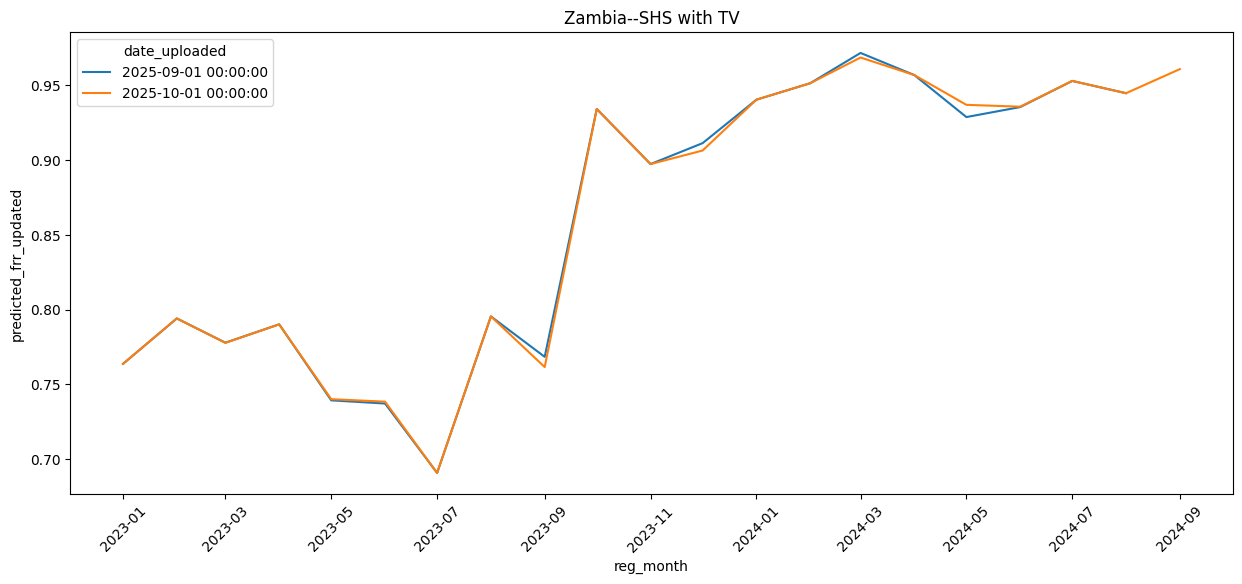

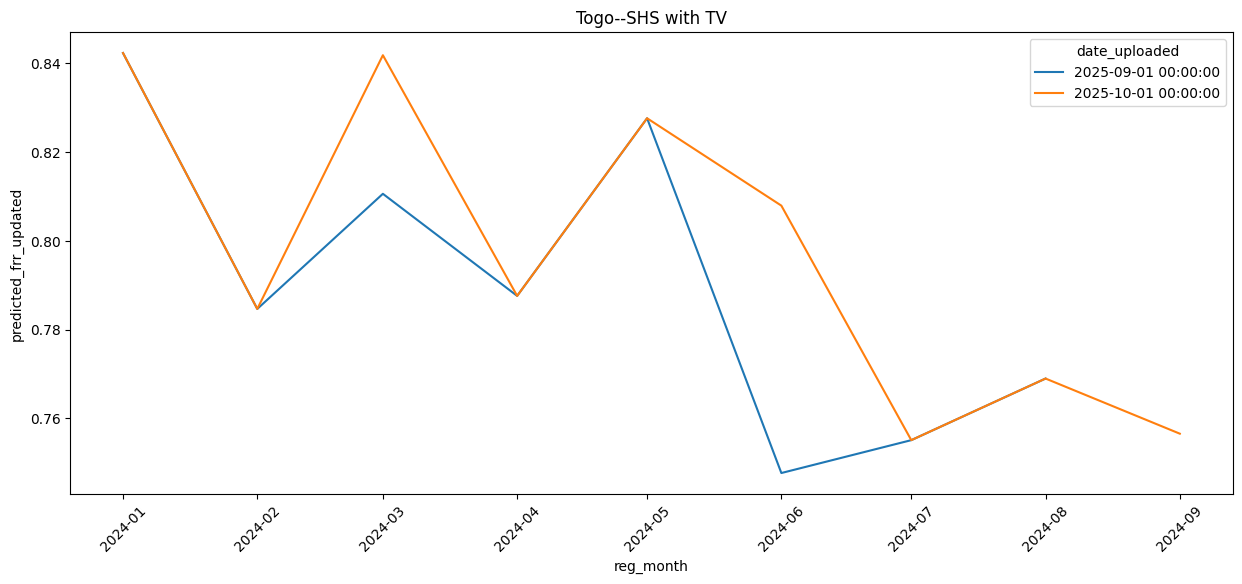

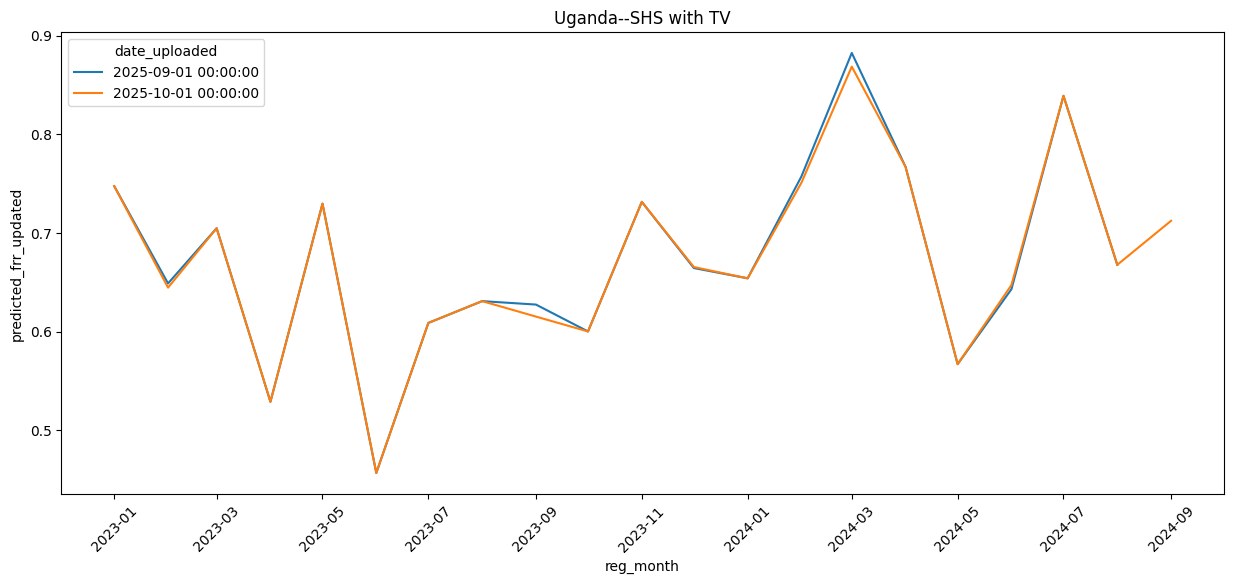

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns

df_product = df.groupby(["country", "product_group","reg_month", "date_uploaded"]).agg(
    count_average=("count_units", lambda x: int(x.mean())),
    predicted_fr = ("predicted_revenue_3_years", "sum"),
    total_fr = ("total_follow_on_revenue_current_usd", "sum")
).reset_index()
df_product["predicted_frr_updated"] = df_product.predicted_fr/df_product.total_fr
df_product = df_product.drop(['total_fr', 'predicted_fr'], axis=1)
# products = ["Lanterns", "Phones", "SHS Entry-Level", "SHS with TV", "SHS without TV", "SHS Entry-Level Upgrade", "SHS with TV Upgrade"]
# df_product = df_product[df_product.product_group.isin(products)]
df_product

for product_group in ["Lanterns", "SHS Entry-Level", "SHS with TV"]:
    for country in ["Kenya", "Tanzania", "Nigeria", "Zambia", "Togo", "Uganda"]:
        plt.figure(figsize=(15, 6))
        sns.lineplot(data=df_product[(df_product.country==country) & (df_product.product_group==product_group) & (df_product.reg_month>="2023-01-01")], x="reg_month", y="predicted_frr_updated",\
                    hue="date_uploaded")
        # sns.lineplot(data=df_product, x="reg_month", y="frr_prediction_50")
        plt.xticks(rotation=45)
        plt.title(f"{country}--{product_group}")
        plt.show()

In [18]:
df_country[df_country.country=="Kenya"]

,country,reg_month,date_uploaded,count_average,predicted_frr_updated
205,Kenya,2016-01-01,2025-09-01,57,0.977491
206,Kenya,2016-01-01,2025-10-01,57,0.977493
207,Kenya,2016-02-01,2025-09-01,152,0.955595
208,Kenya,2016-02-01,2025-10-01,152,0.955594
209,Kenya,2016-03-01,2025-09-01,77,0.952702
...,...,...,...,...,...
409,Kenya,2024-07-01,2025-09-01,58,0.857287
410,Kenya,2024-07-01,2025-10-01,58,0.857820
411,Kenya,2024-08-01,2025-09-01,52,0.849652
412,Kenya,2024-08-01,2025-10-01,52,0.849852


In [19]:
df_product[(df_product["reg_month"]=="2024-05-01") & (df_product.country=="Kenya") & (df_product.product_group=="Lanterns")]

,country,product_group,reg_month,date_uploaded,count_average,predicted_frr_updated
878,Kenya,Lanterns,2024-05-01,2025-09-01,433,0.869871
879,Kenya,Lanterns,2024-05-01,2025-10-01,433,0.869871


In [20]:
0.884858-0.877409

0.007449000000000039

In [21]:
pivoted = df_product.pivot_table(
    index=["country", "product_group","reg_month",],
    columns="date_uploaded",
    values=["predicted_frr_updated", "count_average"]
).reset_index()
pivoted.columns = [
    str(c[0]) if c[1] == "" or pd.isna(c[1]) else f"{c[0]}_{c[1].date()}"
    for c in pivoted.columns.to_flat_index()
]
pivoted["reg_month"] = pd.to_datetime(pivoted["reg_month"])

pivoted["diff"] = pivoted["predicted_frr_updated_2025-10-01"] - pivoted["predicted_frr_updated_2025-09-01"]
pivoted.head()

backtestings = np.array([30, 60, 90, 180, 270, 360, 450, 540, 630, 720], dtype=int)
months = backtestings // 30

base_current = pd.to_datetime("2025-10-01")
base_prev = pd.to_datetime("2025-09-01")

backtesting_month_current = [base_current - pd.DateOffset(months=m+1) for m in months]
backtesting_month_prev = [base_prev - pd.DateOffset(months=m+2) for m in months]

data = {
    "Months": months,
    "backtesting_month_current": backtesting_month_current,
    "backtesting_month_prev": backtesting_month_prev,
    "backtesting_shift": backtestings,
}
backtestings_df = pd.DataFrame(data)

print(backtestings_df)

discrepancies = pd.merge(left=pivoted, right=backtestings_df, left_on="reg_month", right_on="backtesting_month_current", how="left")
discrepancies["backtesting_shift"] = discrepancies["backtesting_shift"].astype("Int64")
discrepancies = discrepancies[discrepancies.backtesting_shift.isin([450, 540, 630, 720])]

# discrepancies["diff"] = (discrepancies["predicted_frr_updated_2025-08"] - discrepancies["predicted_frr_updated_2025-07"]).round(4)*100


   Months backtesting_month_current backtesting_month_prev  backtesting_shift
0       1                2025-08-01             2025-06-01                 30
1       2                2025-07-01             2025-05-01                 60
2       3                2025-06-01             2025-04-01                 90
3       6                2025-03-01             2025-01-01                180
4       9                2024-12-01             2024-10-01                270
5      12                2024-09-01             2024-07-01                360
6      15                2024-06-01             2024-04-01                450
7      18                2024-03-01             2024-01-01                540
8      21                2023-12-01             2023-10-01                630
9      24                2023-09-01             2023-07-01                720


In [22]:
discrepancies_country = discrepancies.groupby(["country", "reg_month", "product_group","backtesting_shift"]).agg(diff2=("diff", "mean")).reset_index()

## DIffs at Backtesting shift

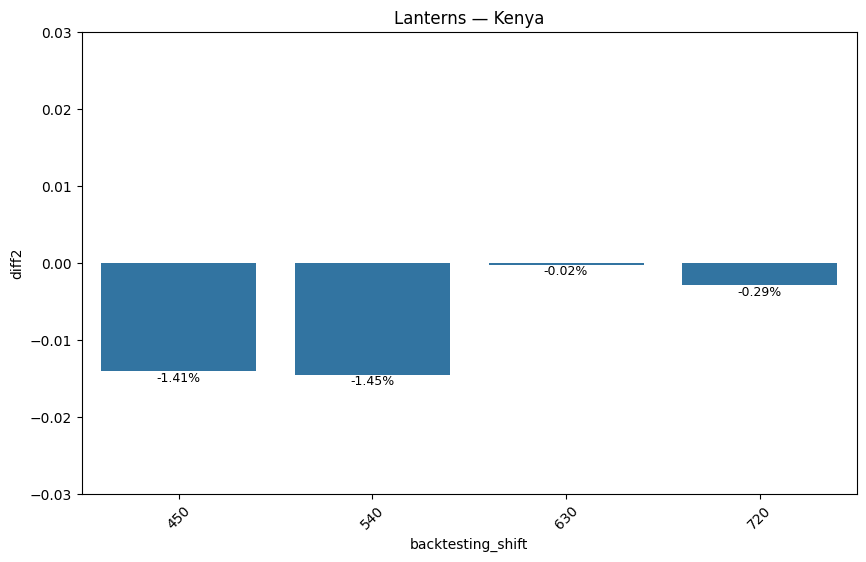

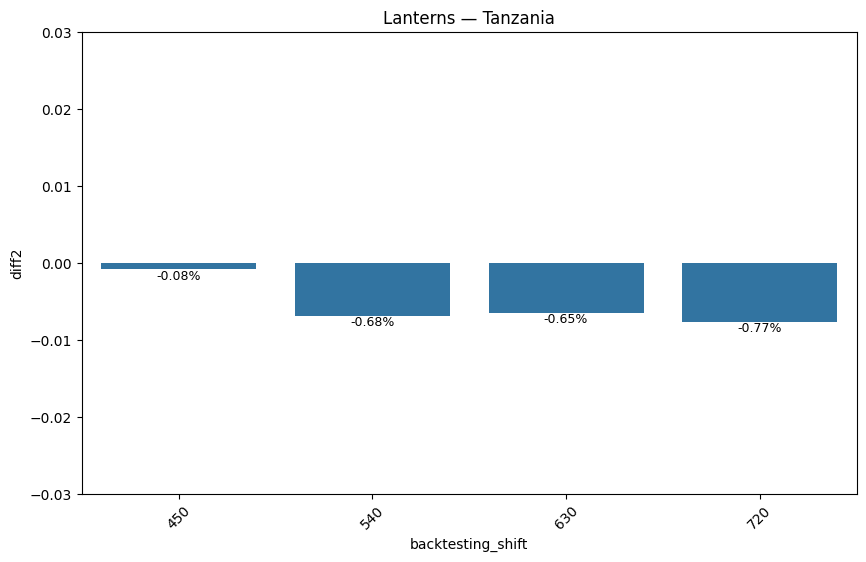

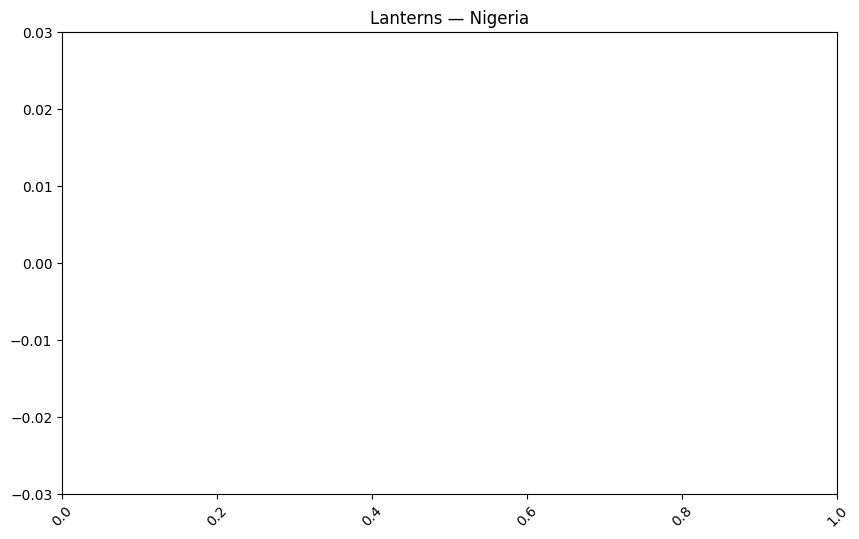

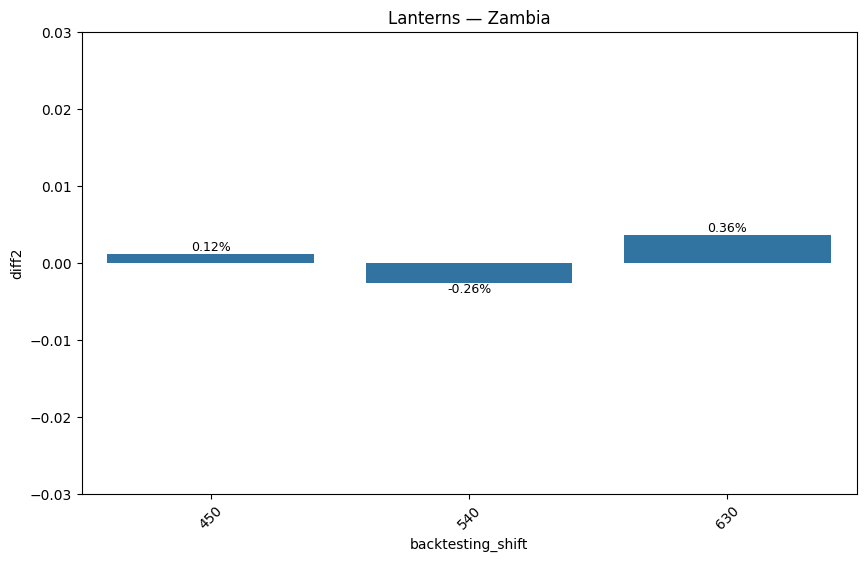

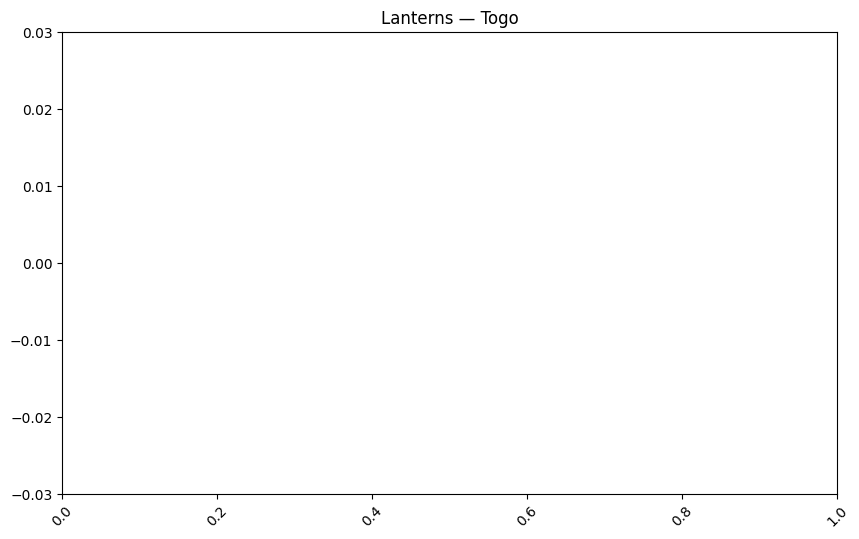

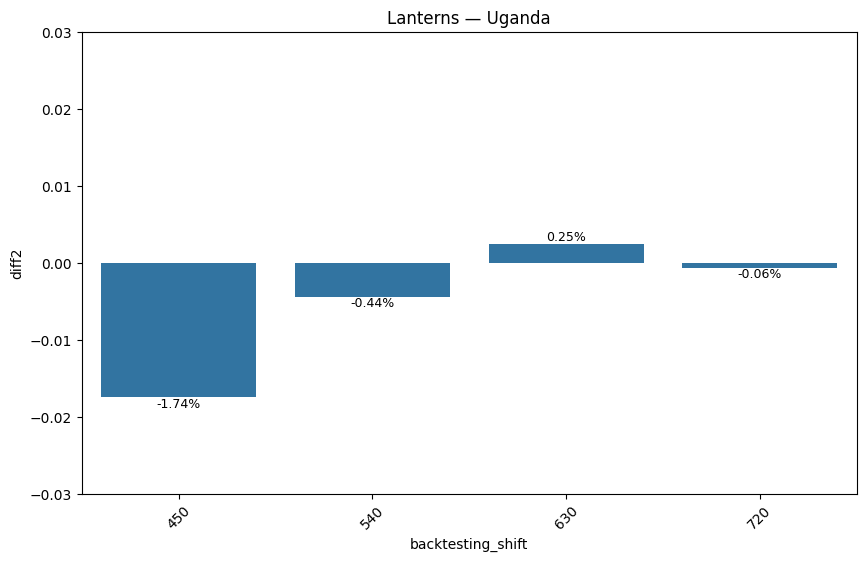

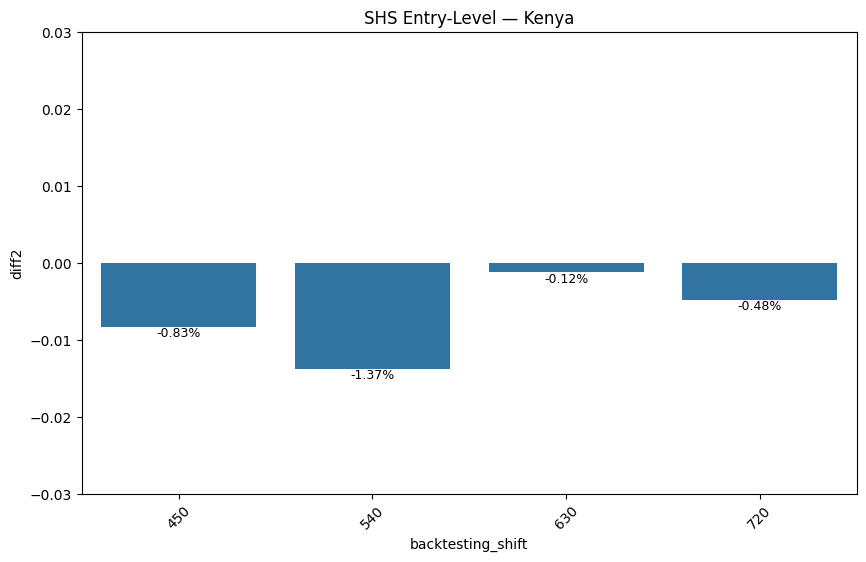

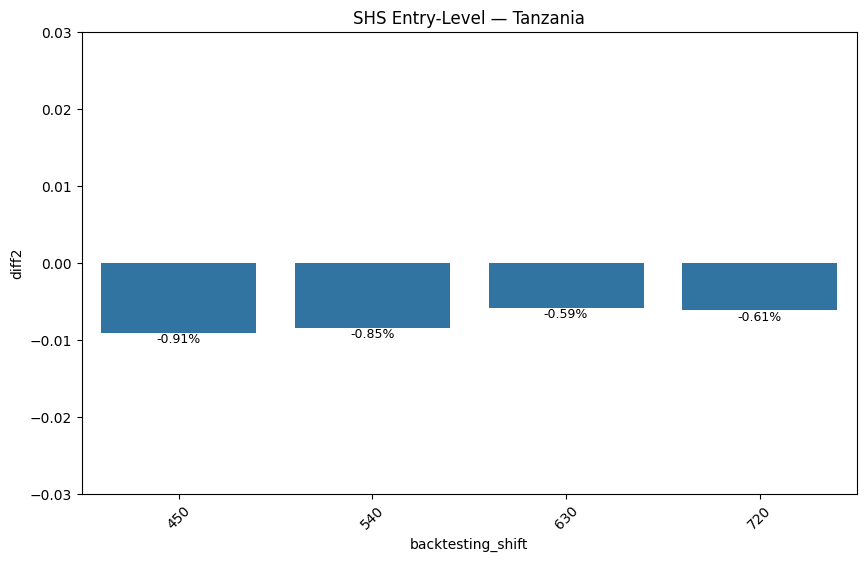

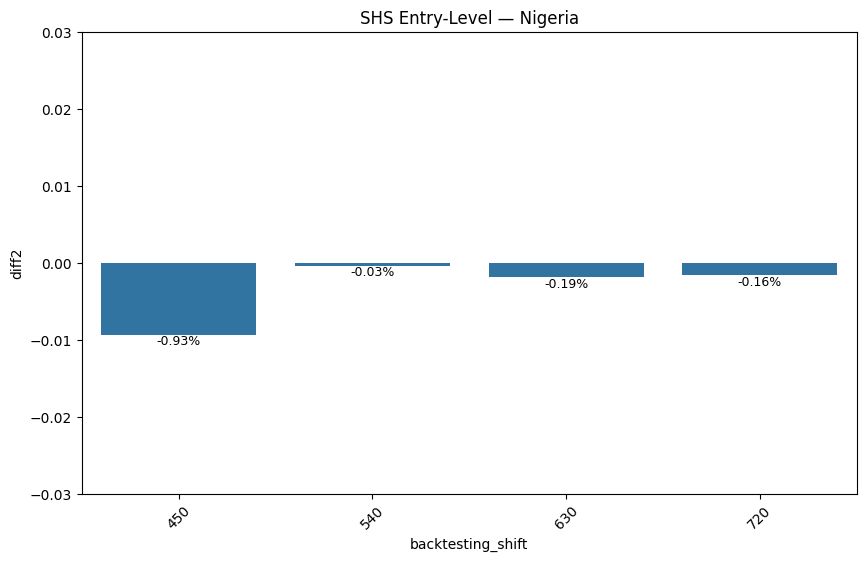

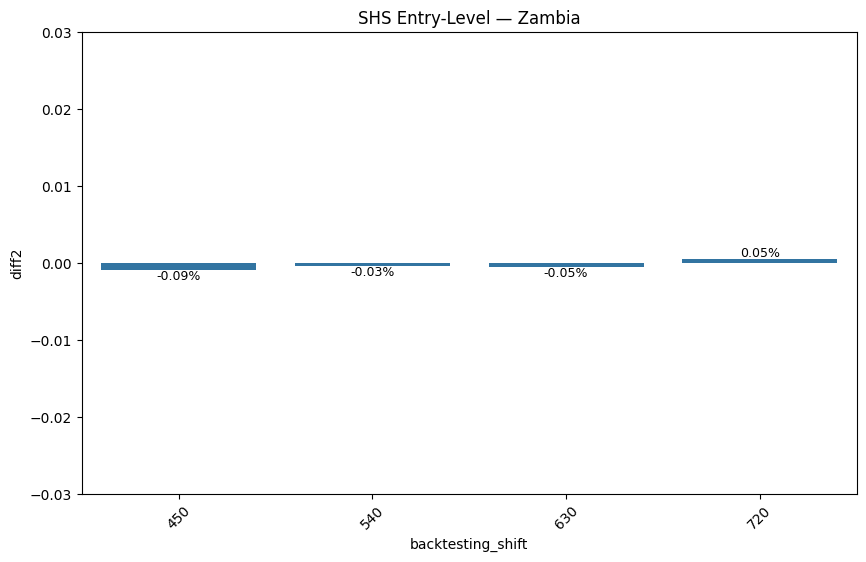

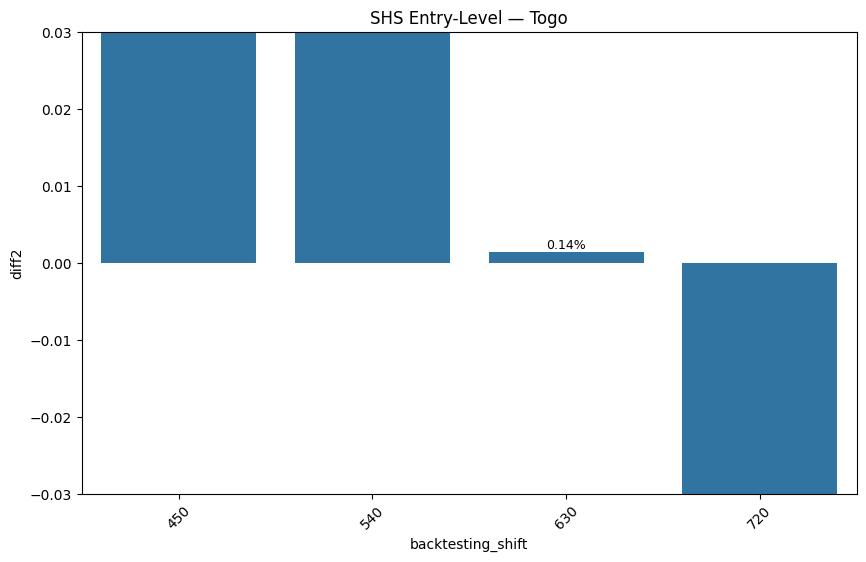

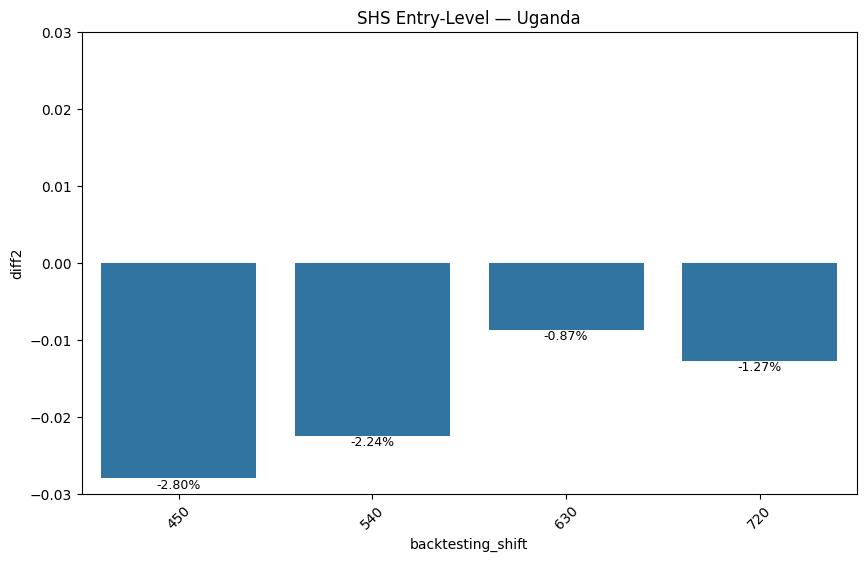

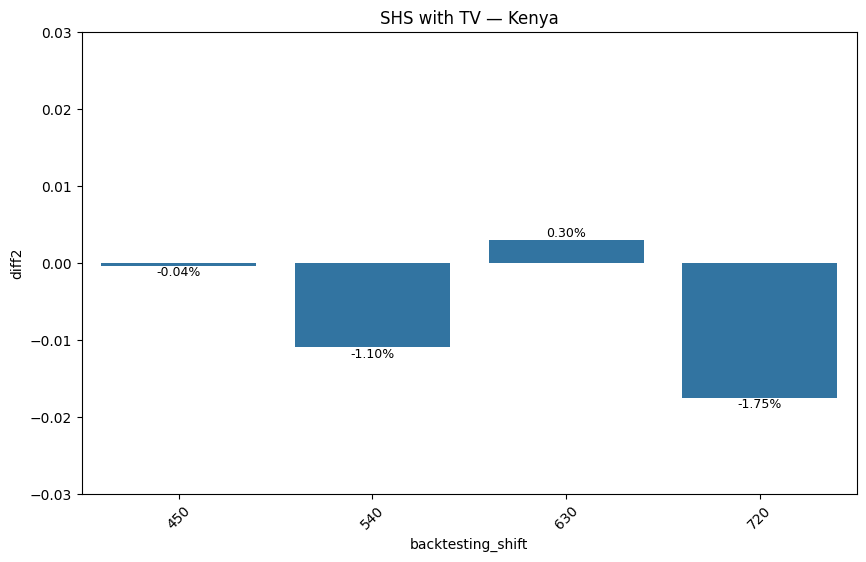

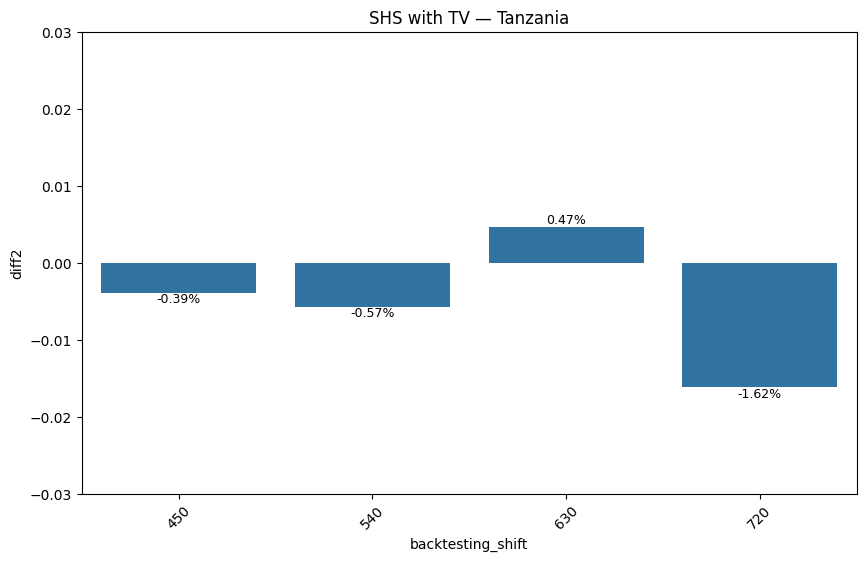

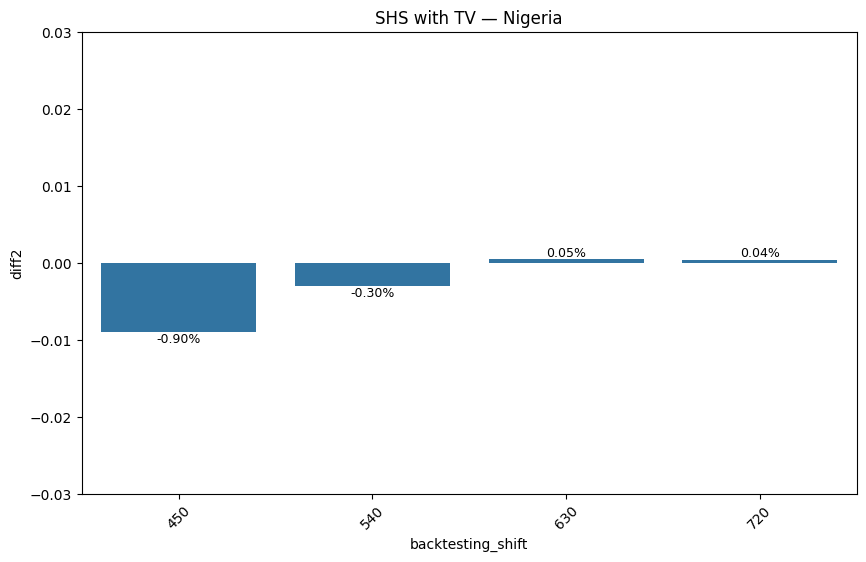

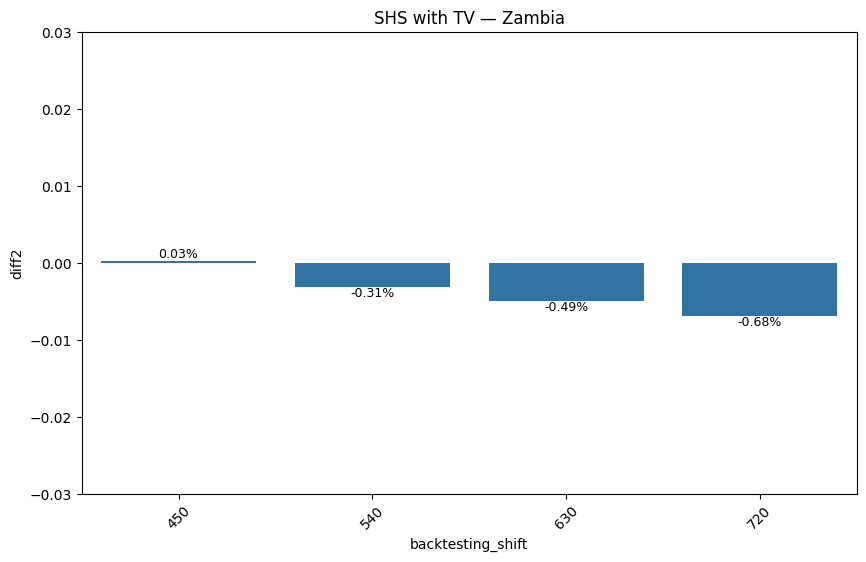

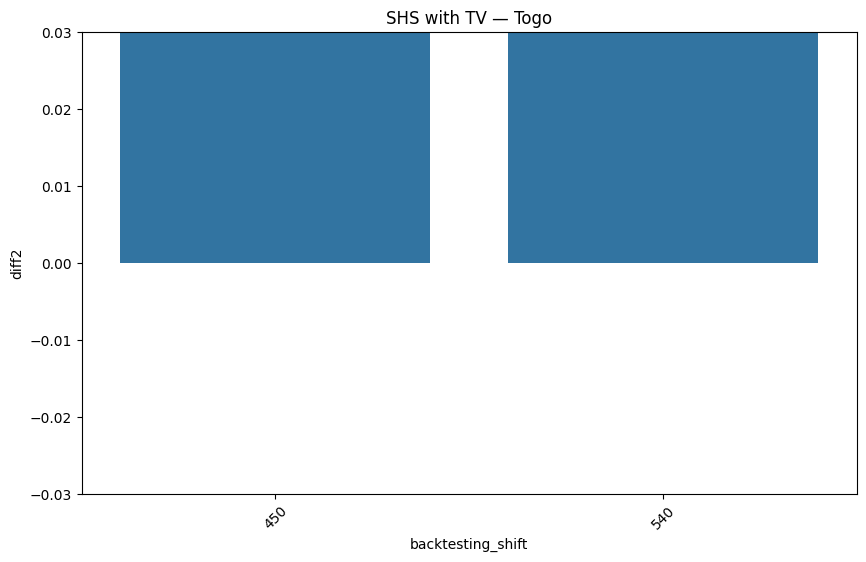

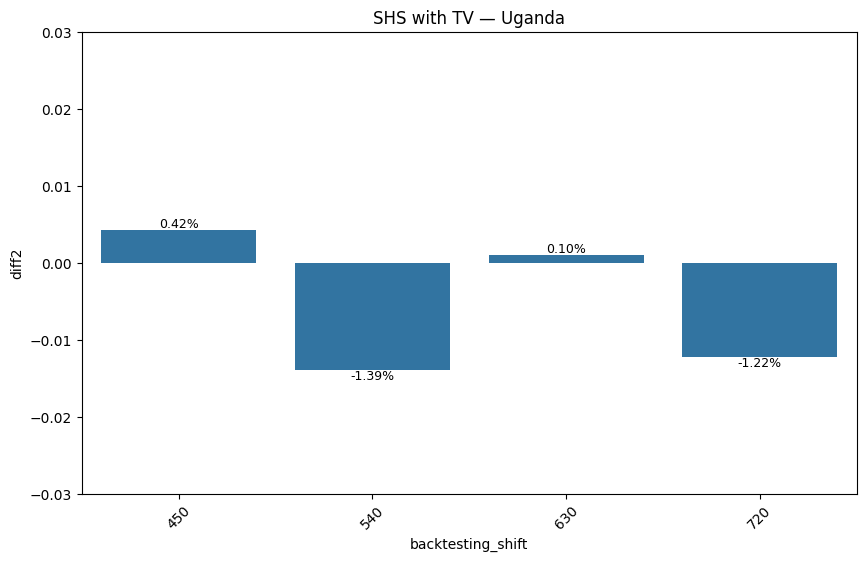

In [23]:
for product_group in ["Lanterns", "SHS Entry-Level", "SHS with TV"]:
    for country in ["Kenya", "Tanzania", "Nigeria", "Zambia", "Togo", "Uganda"]:
        plt.figure(figsize=(10, 6))
        plt.ylim((-0.03, 0.03))

        subset = discrepancies_country[
            (discrepancies_country.country == country) &
            (discrepancies_country.product_group == product_group)
        ]

        ax = sns.barplot(
            data=subset,
            x="backtesting_shift",
            y="diff2"
        )

        # add labels in percent (2 dp)
        for container in ax.containers:
            ax.bar_label(container, labels=[f"{v*100:.2f}%" for v in container.datavalues], fontsize=9)

        plt.xticks(rotation=45)
        plt.title(f"{product_group} — {country}")
        plt.show()

In [24]:
products = ["Lanterns", "Phones", "SHS Entry-Level", "SHS with TV", "SHS without TV", "SHS Entry-Level Upgrade", "SHS with TV Upgrade"]
discrepancies_country[discrepancies_country.product_group.isin(products)].groupby("country").agg(
    mean_diff = ("diff2", "mean"),
    min_diff = ("diff2", "min"),
    max_diff = ("diff2", "max")
).reset_index()

,country,mean_diff,min_diff,max_diff
0,Cameroon,-0.007364,-0.082397,0.026117
1,India,-0.005019,-0.014022,0.001671
2,Kenya,-0.005209,-0.017502,0.009058
3,Malawi,-0.000983,-0.004591,0.005813
4,Mozambique,-0.018622,-0.124455,0.000243
5,Myanmar (Burma),0.000785,-0.002383,0.003335
6,Nigeria,-0.002958,-0.012543,0.005257
7,South Africa,-0.009062,-0.025237,0.007706
8,Tanzania,-0.004924,-0.020901,0.020720
9,Togo,0.021488,-0.032062,0.060208
